# 20Epochs/static=None Explore the predictions of runoff model 
NOTE: only 13 stations were used for this analysis because the static data introduced too many nans! 

In [1]:
from pathlib import Path
import os
import warnings

%load_ext autoreload
%autoreload 2

# ignore warnings for now ...
warnings.filterwarnings('ignore')

if Path('.').absolute().parents[1].name == 'ml_drought':
    os.chdir(Path('.').absolute().parents[1])

!pwd

/home/jovyan/ml_drought


In [2]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import torch

from typing import List, Union, Optional, Tuple, Dict

data_dir = Path('data/')
# data_dir = Path('/Volumes/Lees_Extend/data/zip_data')
# data_dir = Path('/Volumes/Lees_Extend/data/ecmwf_sowc/data/')
# plot_dir = Path('/Users/tommylees/Downloads')

assert data_dir.exists()

In [3]:
import seaborn as sns
from src.utils import drop_nans_and_flatten

from src.analysis import read_train_data, read_test_data, read_pred_data

In [4]:
EXPERIMENT =      'one_timestep_forecast_20epoch'
TRUE_EXPERIMENT = 'one_timestep_forecast'
TARGET_VAR =      'discharge_vol'

# Read in the data

In [5]:
# X_train, y_train = read_train_data(data_dir, experiment=TRUE_EXPERIMENT)
# X_test, y_test = read_test_data(data_dir, experiment=TRUE_EXPERIMENT)
# static_ds = xr.open_dataset(data_dir / "features/static/data.nc")

# ds = xr.merge([y_train, y_test]).sortby('time').sortby('station_id')
# d_ = xr.merge([X_train, X_test]).sortby('time').sortby('station_id')
# ds = xr.merge([ds, d_])
# y_train

In [6]:
# print("TRAINING DATA")
# display(ds)
# print('\n\n')
# print("TARGET DATA")
# display(y_test)

In [7]:
lstm_pred = read_pred_data('rnn', data_dir, experiment=EXPERIMENT)
lstm_pred = lstm_pred.rename({'spatial_unit': 'station_id'})
lstm_pred

Reading all .nc files from: data/models/one_timestep_forecast_20epoch/rnn
All datasets loaded. Now combining ...


<xarray.Dataset>
Dimensions:     (station_id: 13, time: 1734)
Coordinates:
  * station_id  (station_id) object '22007' '27049' '28018' ... '57004' '83010'
  * time        (time) datetime64[ns] 2011-01-01 2011-01-02 ... 2015-09-30
Data variables:
    preds       (time, station_id) float32 14.2915535 6.1847944 ... 0.6997671

[<matplotlib.lines.Line2D at 0x7f79a937b2d0>]

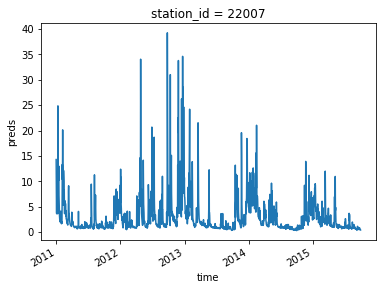

In [8]:
fig, ax = plt.subplots()
lstm_pred.preds.isel(station_id=0).plot(ax=ax)

# Read in the True data

In [9]:
ds = xr.open_dataset(data_dir / 'interim__/camels_preprocessed/data.nc')

# get the times that match
min_time = lstm_pred.time.min().values
max_time = lstm_pred.time.max().values
y_test = ds.discharge_vol.sel(time=slice(min_time, max_time))

In [10]:
y_test

<xarray.DataArray 'discharge_vol' (time: 1734, station_id: 671)>
[1163514 values with dtype=float64]
Coordinates:
  * station_id  (station_id) object '55008' '54027' '102001' ... '54095' '97002'
  * time        (time) datetime64[ns] 2011-01-01 2011-01-02 ... 2015-09-30

In [11]:
# get the stations that match
y_test = y_test.sel(
    station_id=y_test.station_id[
        np.isin(y_test.station_id, lstm_pred.station_id)
    ]
)

In [12]:
y_test

<xarray.DataArray 'discharge_vol' (time: 1734, station_id: 13)>
array([[0.25, 1.91, 1.61, ..., 0.04, 0.45, 2.31],
       [0.22, 1.78, 1.57, ..., 0.02, 0.35, 2.05],
       [0.2 , 1.7 , 1.56, ..., 0.01, 0.3 , 1.85],
       ...,
       [0.08, 0.29, 1.37, ..., 0.  , 0.08, 1.58],
       [0.07, 0.28, 1.35, ..., 0.  , 0.07, 1.46],
       [0.07, 0.27, 1.15, ..., 0.  , 0.07, 1.38]])
Coordinates:
  * station_id  (station_id) object '41029' '55025' '39022' ... '35003' '57004'
  * time        (time) datetime64[ns] 2011-01-01 2011-01-02 ... 2015-09-30

# compare performance

In [13]:
from src.analysis.evaluation import (r2_score, rmse, spatial_rmse, spatial_r2) 
from src.analysis.evaluation import temporal_rmse, temporal_r2

In [14]:
# calculate performance for each station (collapse time)
rmse_da = spatial_rmse(y_test, lstm_pred.preds)
r2_da = spatial_r2(y_test, lstm_pred.preds)

In [15]:
# calculate performance for each station (collapse space)
rmse_time = temporal_rmse(y_test, lstm_pred.preds)
r2_time = temporal_r2(y_test, lstm_pred.preds)

In [16]:
print(lstm_pred.preds.shape)
print(y_test.shape)

(1734, 13)
(1734, 13)


In [17]:
true_da = y_test
pred_da = lstm_pred.preds

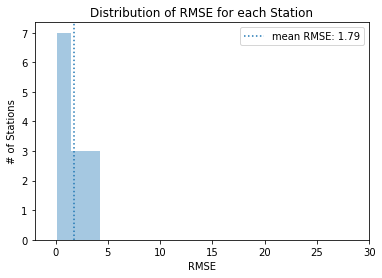

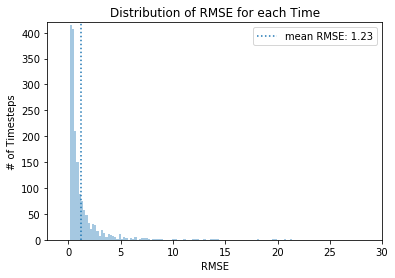

In [18]:
# xlim = [0, 1.05]
# ylim = [0, 200]
xlim = [-2, 30]
ylim = [0, 420]

fig, ax = plt.subplots()
sns.distplot(rmse_da.values, ax=ax, kde=False) #, bins=10)
ax.set_title('Distribution of RMSE for each Station')
ax.set_ylabel('# of Stations')
ax.set_xlabel('RMSE');
ax.axvline(rmse_da.mean(), ls=":", label=f'mean RMSE: {rmse_da.mean().values:.2f}')
ax.set_xlim(xlim)
# ax.set_ylim(ylim)
plt.legend()

fig, ax = plt.subplots()
sns.distplot(rmse_time.values, ax=ax, kde=False, bins=100)
ax.set_title('Distribution of RMSE for each Time')
ax.set_ylabel('# of Timesteps')
ax.set_xlabel('RMSE');
ax.axvline(rmse_time.mean(), ls=":", label=f'mean RMSE: {rmse_time.mean().values:.2f}')
ax.set_xlim(xlim)
ax.set_ylim(ylim)
plt.legend()

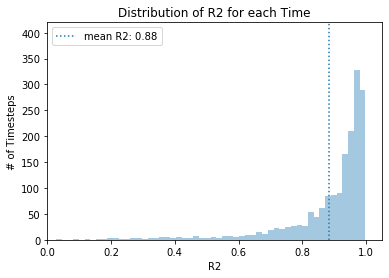

In [19]:
xlim = [0, 1.05]
ylim = [0, 420]


# fig, ax = plt.subplots()
# sns.distplot(r2_da.values, ax=ax, kde=False, bins=100)
# ax.set_title('Distribution of R2 for each Station')
# ax.set_ylabel('# of Stations')
# ax.set_xlabel('R2');
# ax.set_xlim(xlim)
# ax.set_ylim(ylim)
# ax.axvline(r2_da.mean(), ls=":", label=f'mean R2: {r2_da.mean().values:.2f}')
# plt.legend()


fig, ax = plt.subplots()
sns.distplot(r2_time.values, ax=ax, kde=False, bins=100)
ax.set_title('Distribution of R2 for each Time')
ax.set_ylabel('# of Timesteps')
ax.set_xlabel('R2');
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.axvline(r2_time.mean(), ls=":", label=f'mean R2: {r2_time.mean().values:.2f}')
plt.legend()


Text(0.5, 1.0, 'Moving 3M Performance [RMSE]')

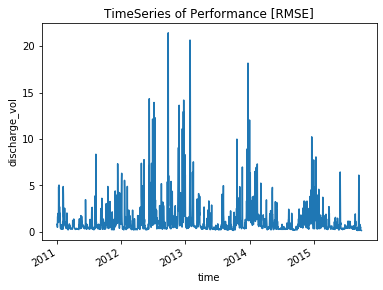

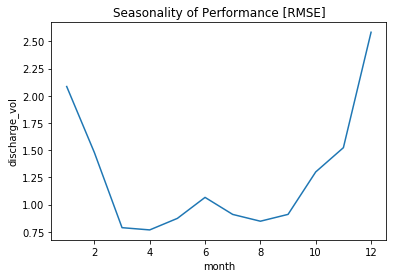

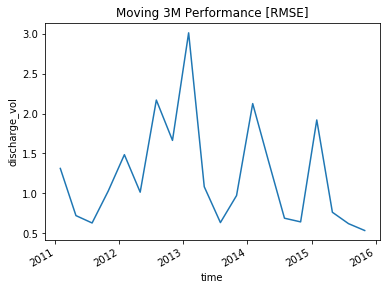

In [20]:
fig, ax = plt.subplots()
rmse_time.plot(ax=ax)
ax.set_title('TimeSeries of Performance [RMSE]')

fig, ax = plt.subplots()
rmse_time.groupby('time.month').mean().plot(ax=ax)
ax.set_title('Seasonality of Performance [RMSE]')

fig, ax = plt.subplots()
rmse_time.resample(time='3M').mean().plot(ax=ax)
ax.set_title('Moving 3M Performance [RMSE]')

Text(0.5, 1.0, 'Moving 3M Performance [R2]')

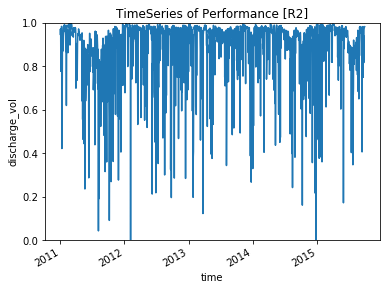

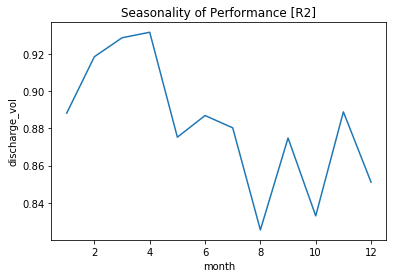

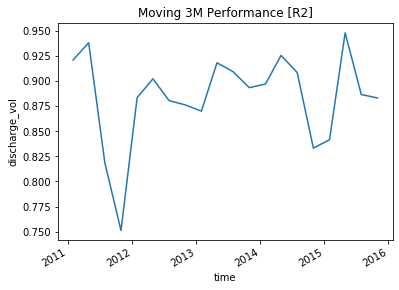

In [21]:
fig, ax = plt.subplots()
r2_time.plot(ax=ax)
ax.set_title('TimeSeries of Performance [R2]')
ax.set_ylim(0, 1)

fig, ax = plt.subplots()
r2_time.groupby('time.month').mean().plot(ax=ax)
ax.set_title('Seasonality of Performance [R2]')

fig, ax = plt.subplots()
r2_time.resample(time='3M').mean().plot(ax=ax)
ax.set_title('Moving 3M Performance [R2]')


In [22]:
from src.analysis.evaluation import join_true_pred_da

In [23]:
df = (
    join_true_pred_da(true_da, pred_da)
    .to_dataframe()
    .reset_index()
    .set_index('time')
)
df.head()

,station_id,discharge_vol,preds
time,,,
2011-01-01,22007,13.80,14.291553
2011-01-02,22007,7.08,9.385386
2011-01-03,22007,5.17,3.871090
2011-01-04,22007,8.36,3.613660
2011-01-05,22007,12.00,11.474503


In [24]:
# rmse and r2 df
metrics_df = rmse_da.to_dataframe().drop(columns='time').rename(columns={"preds": "rmse"}).join(
    r2_da.to_dataframe().drop(columns='time').rename(columns={"preds": "r2"})
).reset_index()
metrics_df.head()

,station_id,rmse,r2
0,22007,4.032677,0.577809
1,27049,1.851078,0.782872
2,28018,4.223198,0.934397
3,31021,1.351719,0.839013
4,31023,0.168423,0.996836


## Compare with the 1 epochs / static=None model

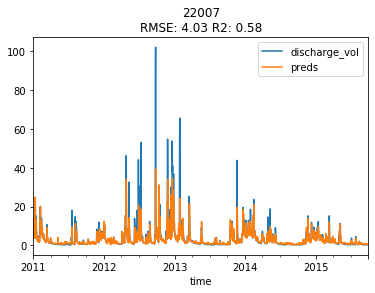

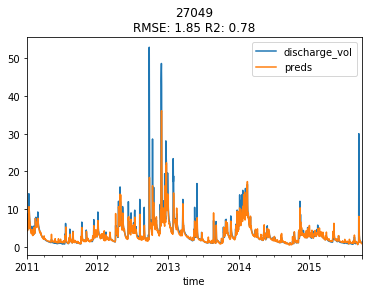

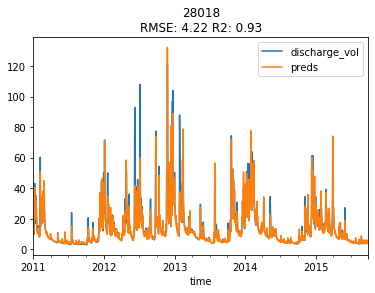

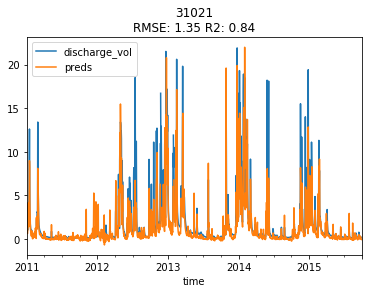

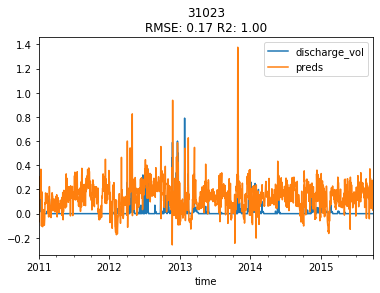

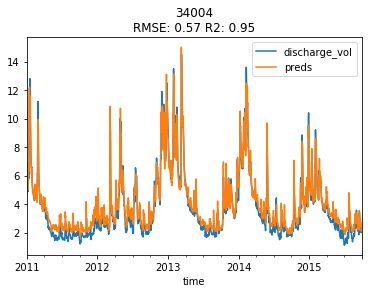

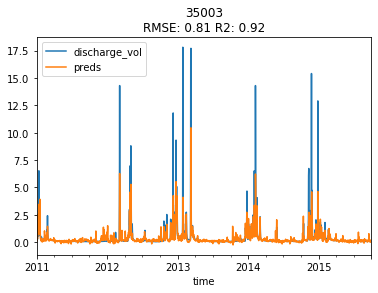

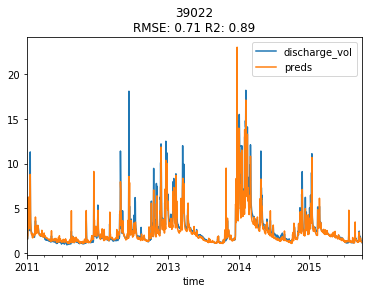

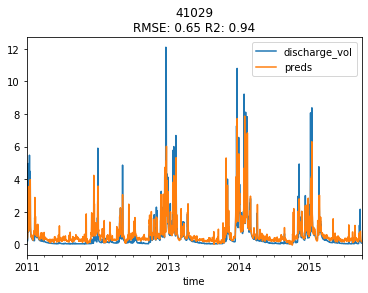

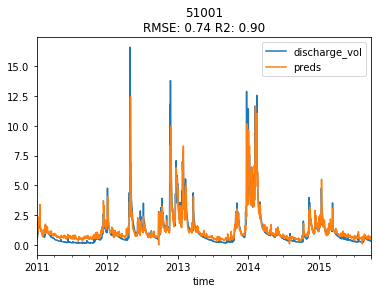

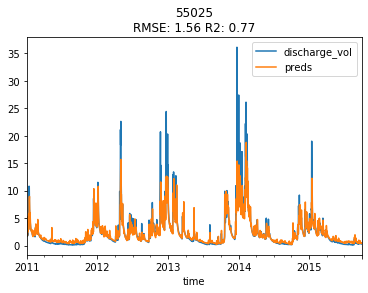

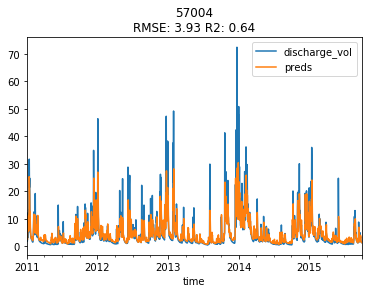

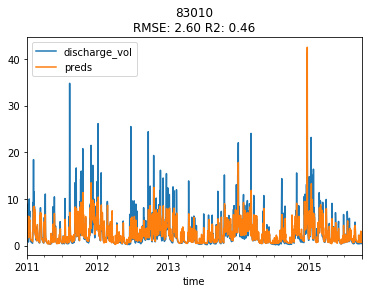

In [25]:
test_stations = ['22007', '27049', '28018', '31021', '31023', '34004', '35003', '39022', '41029', '51001', '55025', '57004', '83010']

for station_id in test_stations:
    fig, ax = plt.subplots()
    df.query(f"station_id == '{station_id}'").drop(columns='station_id').plot(ax=ax)
    rmse_val = metrics_df.query(f"station_id == '{station_id}'").rmse.values[0]
    r2_val = metrics_df.query(f"station_id == '{station_id}'").r2.values[0]
    ax.set_title(f"{station_id}\nRMSE: {rmse_val:.2f} R2: {r2_val:.2f}")

# TODO:
- how to enforce a hard zero on predictions
- e.g. station 31023
- still missing the peaks of the distribution !!
- something to do with baseflow (?)

# let's look at the static data (too many nans!)

note the code in the dataloader has been updated so this cell may not be reproducible any more

basically we removed the variables than had more than 100 missing values:

[src/models/data.py](https://github.com/esowc/ml_drought/pull/156/files#diff-b07d4def3bfdc11dc410d8848b939e1a)
```python
        if static is not None:
            if static == "features":
                self.static = xr.open_dataset(data_path / "features/static/data.nc")
                # ---------------------------------------------------
                # TODO: remove the features with >100 missing values
                # temporary so that we don't have to rerun the engineer (takes time)
                self.static = self.static[
                    [
                        v
                        for v in self.static.data_vars
                        if self.static[v].isnull().sum() < 100
                    ]
                ]
                # ---------------------------------------------------
                if normalize:
                    static_normalizer_path = (
                        data_path / "features/static/normalizing_dict.pkl"
                    )
                    with static_normalizer_path.open("rb") as f:
                        self.static_normalizing_dict = pickle.load(f)
            if static == "embeddings":
                # in case no static dataset was generated, we use the first
                # historical dataset
                self.static, self.max_loc_int = self._loc_to_int(
                    xr.open_dataset(self.data_files[0] / "x.nc")
                )

```

In [55]:
from src.models import load_model

ealstm = load_model(data_dir / f"models/{EXPERIMENT}/rnn/model.pt")

In [64]:
dl = ealstm.get_dataloader(mode='train')
train_iter = iter(dl)
static_ds = train_iter.static
static_ds.isnull().sum()

<xarray.Dataset>
Dimensions:                       ()
Data variables:
    inter_high_perc               int64 0
    inter_mod_perc                int64 0
    inter_low_perc                int64 0
    frac_high_perc                int64 0
    frac_mod_perc                 int64 0
    frac_low_perc                 int64 0
    no_gw_perc                    int64 0
    low_nsig_perc                 int64 0
    nsig_low_perc                 int64 0
    gauge_lat                     int64 0
    gauge_lon                     int64 0
    gauge_elev                    int64 0
    area                          int64 0
    dpsbar                        int64 2
    elev_mean                     int64 2
    elev_min                      int64 0
    elev_10                       int64 0
    elev_50                       int64 0
    elev_90                       int64 0
    elev_max                      int64 0
    sand_perc                     int64 0
    sand_perc_missing             int64 0
    silt_perc                     int64 0
    silt_perc_missing             int64 0
    clay_perc                     int64 0
    clay_perc_missing             int64 0
    organic_perc                  int64 0
    organic_perc_missing          int64 0
    bulkdens                      int64 0
    bulkdens_missing              int64 0
    bulkdens_5                    int64 0
    bulkdens_50                   int64 0
    bulkdens_95                   int64 0
    tawc                          int64 0
    tawc_missing                  int64 0
    tawc_5                        int64 0
    tawc_50                       int64 0
    tawc_95                       int64 0
    porosity_cosby                int64 0
    porosity_cosby_missing        int64 0
    porosity_cosby_5              int64 0
    porosity_cosby_50             int64 0
    porosity_cosby_95             int64 0
    porosity_hypres               int64 0
    porosity_hypres_missing       int64 0
    porosity_hypres_5             int64 0
    porosity_hypres_50            int64 0
    porosity_hypres_95            int64 0
    conductivity_cosby            int64 0
    conductivity_cosby_missing    int64 0
    conductivity_cosby_5          int64 0
    conductivity_cosby_50         int64 0
    conductivity_cosby_95         int64 0
    conductivity_hypres           int64 0
    conductivity_hypres_missing   int64 0
    conductivity_hypres_5         int64 0
    conductivity_hypres_50        int64 0
    conductivity_hypres_95        int64 0
    root_depth                    int64 0
    root_depth_missing            int64 0
    root_depth_5                  int64 0
    root_depth_50                 int64 0
    root_depth_95                 int64 0
    soil_depth_pelletier          int64 0
    soil_depth_pelletier_missing  int64 0
    soil_depth_pelletier_5        int64 0
    soil_depth_pelletier_50       int64 0
    soil_depth_pelletier_95       int64 0
    q_mean                        int64 0
    runoff_ratio                  int64 0
    stream_elas                   int64 0
    slope_fdc                     int64 3
    baseflow_index                int64 0
    baseflow_index_ceh            int64 0
    hfd_mean                      int64 0
    Q5                            int64 0
    Q95                           int64 0
    high_q_freq                   int64 0
    high_q_dur                    int64 0
    low_q_freq                    int64 0
    low_q_dur                     int64 0
    zero_q_freq                   int64 0
    p_mean                        int64 0
    pet_mean                      int64 0
    aridity                       int64 0
    p_seasonality                 int64 0
    frac_snow                     int64 0
    high_prec_freq                int64 0
    high_prec_dur                 int64 0
    low_prec_freq                 int64 0
    low_prec_dur                  int64 0
    dwood_perc                    int64 0
    ewood_perc                    int64 0
    grass_perc          

In [71]:
static_ds[[v for v in static_ds.data_vars if static_ds[v].isnull().sum() < 100]].isnull().sum()

<xarray.Dataset>
Dimensions:                       ()
Data variables:
    inter_high_perc               int64 0
    inter_mod_perc                int64 0
    inter_low_perc                int64 0
    frac_high_perc                int64 0
    frac_mod_perc                 int64 0
    frac_low_perc                 int64 0
    no_gw_perc                    int64 0
    low_nsig_perc                 int64 0
    nsig_low_perc                 int64 0
    gauge_lat                     int64 0
    gauge_lon                     int64 0
    gauge_elev                    int64 0
    area                          int64 0
    dpsbar                        int64 2
    elev_mean                     int64 2
    elev_min                      int64 0
    elev_10                       int64 0
    elev_50                       int64 0
    elev_90                       int64 0
    elev_max                      int64 0
    sand_perc                     int64 0
    sand_perc_missing             int64 0
    silt_perc                     int64 0
    silt_perc_missing             int64 0
    clay_perc                     int64 0
    clay_perc_missing             int64 0
    organic_perc                  int64 0
    organic_perc_missing          int64 0
    bulkdens                      int64 0
    bulkdens_missing              int64 0
    bulkdens_5                    int64 0
    bulkdens_50                   int64 0
    bulkdens_95                   int64 0
    tawc                          int64 0
    tawc_missing                  int64 0
    tawc_5                        int64 0
    tawc_50                       int64 0
    tawc_95                       int64 0
    porosity_cosby                int64 0
    porosity_cosby_missing        int64 0
    porosity_cosby_5              int64 0
    porosity_cosby_50             int64 0
    porosity_cosby_95             int64 0
    porosity_hypres               int64 0
    porosity_hypres_missing       int64 0
    porosity_hypres_5             int64 0
    porosity_hypres_50            int64 0
    porosity_hypres_95            int64 0
    conductivity_cosby            int64 0
    conductivity_cosby_missing    int64 0
    conductivity_cosby_5          int64 0
    conductivity_cosby_50         int64 0
    conductivity_cosby_95         int64 0
    conductivity_hypres           int64 0
    conductivity_hypres_missing   int64 0
    conductivity_hypres_5         int64 0
    conductivity_hypres_50        int64 0
    conductivity_hypres_95        int64 0
    root_depth                    int64 0
    root_depth_missing            int64 0
    root_depth_5                  int64 0
    root_depth_50                 int64 0
    root_depth_95                 int64 0
    soil_depth_pelletier          int64 0
    soil_depth_pelletier_missing  int64 0
    soil_depth_pelletier_5        int64 0
    soil_depth_pelletier_50       int64 0
    soil_depth_pelletier_95       int64 0
    q_mean                        int64 0
    runoff_ratio                  int64 0
    stream_elas                   int64 0
    slope_fdc                     int64 3
    baseflow_index                int64 0
    baseflow_index_ceh            int64 0
    hfd_mean                      int64 0
    Q5                            int64 0
    Q95                           int64 0
    high_q_freq                   int64 0
    high_q_dur                    int64 0
    low_q_freq                    int64 0
    low_q_dur                     int64 0
    zero_q_freq                   int64 0
    p_mean                        int64 0
    pet_mean                      int64 0
    aridity                       int64 0
    p_seasonality                 int64 0
    frac_snow                     int64 0
    high_prec_freq                int64 0
    high_prec_dur                 int64 0
    low_prec_freq                 int64 0
    low_prec_dur                  int64 0
    dwood_perc                    int64 0
    ewood_perc                    int64 0
    grass_perc          

In [62]:
dir(train_iter)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__next__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_add_extra_dims',
 '_calculate_aggs',
 '_calculate_change',
 '_calculate_historical',
 '_calculate_historical_target',
 '_calculate_latlons',
 '_calculate_static',
 '_calculate_target_months',
 '_get_prev_y_var',
 'apply_spatial_mask',
 'batch_file_size',
 'build_loc_to_idx_mapping',
 'calculate_latlons',
 'calculate_normalizing_array',
 'calculate_static_normalizing_array',
 'clear_nans',
 'data_files',
 'device',
 'ds_folder_to_np',
 'experiment',
 'get_current_array',
 'idx',
 'ignore_vars',
 'max_idx',
 'normalize_y',
 'normalizing_array',
 'normalizing_array_static',
 'normalizing_array_ym',
 'normalizing_dict',
 'predict_delta',
 'reducing_dims',
 'shuffle',
 'spatial_mask',
 'static',
 'static_array',
 'static_normalizing_dict',
 'surrounding_pixels',
 'timestep_aggs',
 'to_tensor',
 'use_prev_y_var']